# "Deep Learning assisted Surrogate Modeling of Large-Scale Power Grids"
# Authors:  Asif Hamid, Danish Rafiq, S.A.Nahvi, M.A.Bazaz 

# This file simulates the AE-LSTM method for IEEE-118 Bus System

In [32]:
# Testing IEEE Model with dense layers only
# testing with deltas only
# SM models
# tesing LSTM 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers, models, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from numpy.linalg import norm
from scipy import stats 

# Loading the data

In [33]:
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df
def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# importing data 
import scipy.io as sio
train= sio.loadmat('Training_data118.mat')   # load the desired model
snapshots_train=train['xFOM_train']
test= sio.loadmat('Testing_data118.mat')   # load the desired model
snapshots_all=test['xFOM_test']
tspan=100
snapshots_train=snapshots_train[:,:]
snapshots_valid=snapshots_all[0:tspan,:]
snapshots_test=snapshots_all[3800:3900,:]
snapshots_train=outliers(snapshots_train,10)
print (snapshots_train.shape)
print (snapshots_all.shape)

(5000, 236)
(4900, 236)


In [34]:
latent_dim=4
input=output=snapshots_train.shape[1]
first=input
# Autoencoder
encoder_input = Input(shape=(input, 1), name='IEEE118')
o1 = Flatten()(encoder_input)
o2 = Dense(first, activation="selu")(o1)
encoder_output = Dense(latent_dim, activation=None)(o2)
encoder = Model(encoder_input, encoder_output, name='encoder')
#encoder.summary()
decoder_input = Dense(latent_dim, activation='selu')(encoder_output)
decoder_input3= Dense(first, activation='selu')(decoder_input)
decoder_output = Dense(output, activation=None)(decoder_input3)
decoder = Model(decoder_input, decoder_output, name='decoder')
#decoder.summary()
# defining autoencoder
ae_output=decoder(encoder(encoder_input))
autoencoder = Model(encoder_input, ae_output, name='autoencoder')
autoencoder.summary()
weights_filepath = 'best_weights118_ae.h5'

# design network
lrate = 0.001
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]
epoch_num=500
batch_size=50
autoencoder.compile(optimizer=my_adam, loss='MeanSquaredError',metrics=[coeff_determination,'accuracy'])
#autoencoder.fit(snapshots_train, snapshots_train,
 #               epochs=epoch_num,  batch_size=batch_size,
  #                        callbacks=callbacks_list
   #             ,validation_data=(snapshots_valid, snapshots_valid))
               # shuffle=True)                                 #uncomment to retrain the model
autoencoder.load_weights(weights_filepath)
encoded_test = K.eval(encoder(snapshots_test.astype('float32')))
autoencoder_output = autoencoder.predict(snapshots_test)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IEEE118 (InputLayer)        [(None, 236, 1)]          0         
                                                                 
 encoder (Functional)        (None, 4)                 56880     
                                                                 
 decoder (Functional)        (None, 236)               57112     
                                                                 
Total params: 113,992
Trainable params: 113,992
Non-trainable params: 0
_________________________________________________________________


C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0.009538265041981355


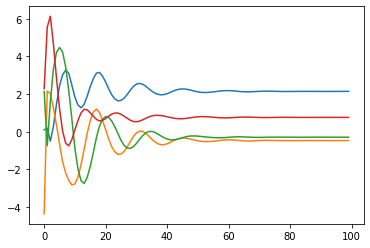

In [35]:
# plotting the latent dimension
# mode plotting
norm_1=norm(snapshots_test-autoencoder_output)/norm(snapshots_test)
print(norm_1)
plt.plot(encoded_test[:,:])
plt.show()

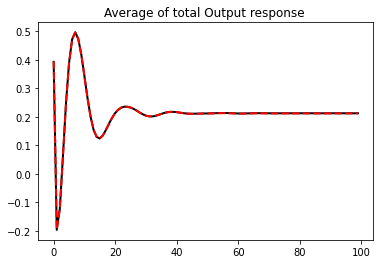

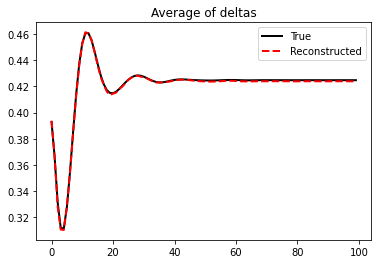

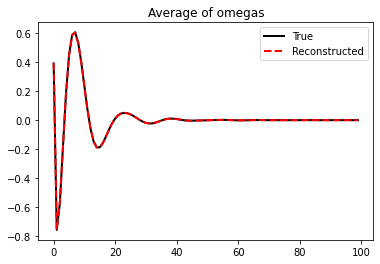

In [36]:
# comparison of average of true and predicted
true_mean=snapshots_test.mean(axis=1)
autoencoder_output_mean=autoencoder_output.mean(axis=1)
plt.plot(true_mean,'k',lw=2)
#plt.show()
plt.plot(autoencoder_output_mean,'r--',lw=2)
plt.title('Average of total Output response ')
plt.show()
# average of deltas and omegas
#d=snapshots_test.shape[1/2]
d=118
delta=snapshots_test[:,:d]
delta_mean=delta.mean(axis=1)
omega=snapshots_test[:,d:]
omega_mean=omega.mean(axis=1)

delta_pred=autoencoder_output[:,:d]
delta_pred_mean=delta_pred.mean(axis=1)

plt.plot(delta_mean,'k',linewidth=2)
plt.savefig('deltaout.png')
plt.plot(delta_pred_mean,'r--',linewidth=2)
plt.title('Average of deltas')
l=['True','Reconstructed']
plt.legend(l)
plt.show()
omega_pred=autoencoder_output[:,d:]
omega_pred_mean=omega_pred.mean(axis=1)

plt.plot(omega_mean,'k',linewidth=2)
plt.plot(omega_pred_mean,'r--',lw=2)
l=['True','Reconstructed']
plt.legend(l)
plt.title('Average of omegas')
plt.show()

# LSTM 

In [37]:
# generate encoded data for lstm
rnum_vals_train=50 # batch size
num_time_steps=tspan
#rnum_vals_test=300
#from sklearn.preprocessing import MinMaxScaler,normalize
# Train
encoded_train = K.eval(encoder(snapshots_train.astype('float32')))
encoded_train=outliers(encoded_train,10)
#endcoded_train=normalize(encoded_train)
# Reshape
lstm_training_data = encoded_train.reshape(rnum_vals_train,num_time_steps,latent_dim)
num_train_snapshots=rnum_vals_train
time_window=6 #try
total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1] # 45*600=27000
total_size_sim = np.shape(lstm_training_data)[1]                             # 600
input_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window
                           ,time_window,latent_dim))
output_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,latent_dim))
# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim):
        input_seq[sample,:,:] = lstm_training_data[snum,t-time_window:t,:]
        output_seq[sample,:] = lstm_training_data[snum,t,0:latent_dim]
        sample = sample + 1

In [38]:
# generate validation data for lstm
rnum_vals_train=1 # batch size
num_time_steps=tspan
num_train_snapshots=rnum_vals_train
# Reshape
encoded_valid=K.eval(encoder(snapshots_valid.astype('float32')))
lstm_training_data_valid = encoded_valid.reshape(rnum_vals_train,num_time_steps,latent_dim)
total_size_valid = np.shape(lstm_training_data_valid)[0]*np.shape(lstm_training_data_valid)[1] # 45*600=27000
total_size_sim_valid = np.shape(lstm_training_data_valid)[1]                             # 600
input_seq_valid = np.zeros(shape=(total_size_valid-num_train_snapshots*time_window
                           ,time_window,latent_dim))
output_seq_valid = np.zeros(shape=(total_size_valid-num_train_snapshots*time_window,latent_dim))
# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim_valid):
        input_seq_valid[sample,:,:] = lstm_training_data_valid[snum,t-time_window:t,:]
        output_seq_valid[sample,:] = lstm_training_data_valid[snum,t,0:latent_dim]
        sample = sample + 1

In [39]:
# Model architecture
units=40
lstm_model = models.Sequential()
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(LSTM(units,return_sequences=True))
lstm_model.add(LSTM(units,return_sequences=False))
#lstm_model.add(Dropout(0.1))#try # 80 showing best response
#lstm_model.add(LSTM(units,return_sequences=False))
#lstm_model.add(Dropout(0.1))#
#lstm_model.add(LSTM(80,return_sequences=False))
#lstm_model.add(LSTM(40,input_shape=(time_window, latent_dim),return_sequences=False))
lstm_model.add(Dense(latent_dim, activation=None))

# design network
lstm_filepath = 'lstm_weights118.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint(lstm_filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint]
# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error')

lstm_model.summary()
#if mode == 'train':
# training parameters
batch_size_lstm=50 # try batch size=590
num_epochs = 500 # try
#lstm_train_history = lstm_model.fit(input_seq,output_seq, epochs=num_epochs, 
                               #     batch_size=batch_size_lstm, callbacks=lstm_callbacks_list   #,shuffle=True
                                #  ,validation_data=[input_seq_valid,output_seq_valid] )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 6, 40)             7200      
                                                                 
 lstm_6 (LSTM)               (None, 6, 40)             12960     
                                                                 
 lstm_7 (LSTM)               (None, 6, 40)             12960     
                                                                 
 lstm_8 (LSTM)               (None, 6, 40)             12960     
                                                                 
 lstm_9 (LSTM)               (None, 40)                12960     
                                                                 
 dense_11 (Dense)            (None, 4)                 164       
                                                                 
Total params: 59,204
Trainable params: 59,204
Non-trai

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Testing

In [40]:
lstm_model.load_weights(lstm_filepath)
# data for testing LSTM
rnum_vals_test=1
num_time_steps=tspan
#rnum_vals_test=300
#time_window=4
num_test_snapshots=rnum_vals_test
lstm_testing_data = encoded_test.reshape(rnum_vals_test,num_time_steps,latent_dim)
#scaler = MinMaxScaler()
#stm_testing_data[0,:,:]=scaler.fit_transform(lstm_testing_data[0,:,:])
total_size = np.shape(lstm_testing_data)[0]*np.shape(lstm_testing_data)[1]
total_size_sim = np.shape(lstm_testing_data)[1]
# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,latent_dim))
output_seq = np.zeros(shape=(total_size-num_test_snapshots*time_window,latent_dim))
output_seq_pred = np.zeros(shape=(total_size-num_test_snapshots*time_window,latent_dim))
#lstm_model.load_weights(lstm_filepath)
# Setting up inputs
sample = 0
for snum in range(num_test_snapshots):
    input_seq[0,:,:] = lstm_testing_data[snum,0:time_window,:]
    for t in range(time_window,total_size_sim):
#         input_seq[0,:,:] = lstm_testing_data[snum,t-time_window:t,:]
        output_seq_pred[sample,:] = lstm_model.predict(input_seq[0:latent_dim,:,:])[0,:]   # [0,:]
        output_seq[sample,:] = lstm_testing_data[snum,t,0:latent_dim]
        input_seq[0,0:time_window-1,:] = input_seq[0,1:,:] 
        input_seq[0,time_window-1,:latent_dim] = output_seq_pred[sample,:]
        sample = sample + 1
output_seq_pred = np.concatenate((encoded_test[0:6,:],output_seq_pred),axis=0)
output_seq_pred.shape

(100, 4)

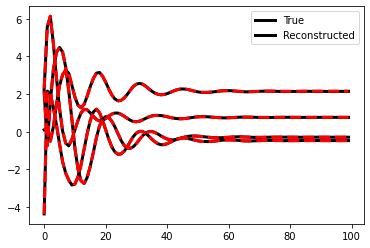

In [41]:
#output_seq_pred
mode=9
plt.plot(encoded_test[:,:mode],'k',lw=3)
#plt.show()
plt.plot(output_seq_pred[:,:mode],'r--',lw=3)
#plt.show()
l=['True','Reconstructed']
plt.legend(l)
plt.savefig('Results/Zenc_vs_Zlstm')
# evolution in physical space
decoded_lstm= K.eval(decoder(output_seq_pred.astype('float32')))

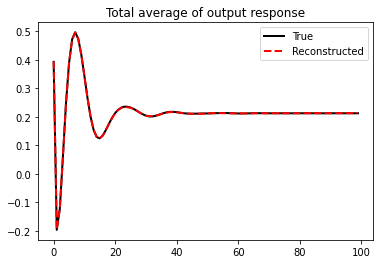

In [42]:
# plotting of averages
# comparison of average of true and predicted
snapshots_mean=snapshots_test.mean(axis=1)
decoded_lstm_mean=decoded_lstm.mean(axis=1)
plt.plot(snapshots_mean,'k',lw=2)
#plt.show()
plt.plot(decoded_lstm_mean,'r--',lw=2)
plt.title('Total average of output response')
#plt.show()
l=['True','Reconstructed']
plt.legend(l)
plt.savefig('Results/AverageOutput')
# average of deltas and omegas
#d=snapshots_test.shape[1/2]
d=118
delta=snapshots_test[:,:d]
delta_mean=delta.mean(axis=1)
omega=snapshots_test[:,d:]
omega_mean=omega.mean(axis=1)
delta_pred=decoded_lstm[:,:d]
delta_pred_mean=delta_pred.mean(axis=1)
omega_pred=decoded_lstm[:,d:]
omega_pred_mean=omega_pred.mean(axis=1)

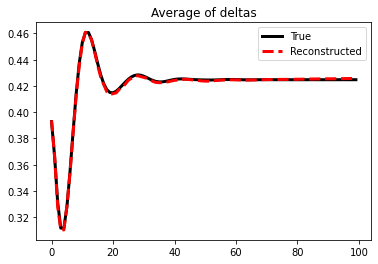

In [43]:
# Plotting average of deltas of generators
plt.plot(delta_mean,'k',linewidth=3)
plt.plot(delta_pred_mean,'r--',linewidth=3)
plt.title('Average of deltas')
l=['True','Reconstructed']
plt.legend(l)
#plt.show()
plt.savefig('Results/AverageDeltas')

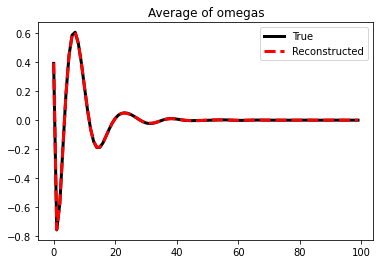

In [44]:
# Plotting average of omegas of generators
plt.plot(omega_mean,'k',linewidth=3)
plt.plot(omega_pred_mean,'r--',lw=3)
l=['True','Reconstructed']
plt.legend(l)
plt.title('Average of omegas')
#plt.show()
plt.savefig('Results/AverageOmegas')

In [45]:
# calculating norm
norm2_lstm=norm(snapshots_test-decoded_lstm)/norm(snapshots_test)
norm2_lstm_delta=norm(delta-delta_pred)/norm(delta)
norm2_lstm_omega=norm(omega-omega_pred)/norm(omega)
print('L2 Norm total: ',norm2_lstm)
print('L2 Norm delta: ',norm2_lstm_delta)
print('L2 Norm omega: ',norm2_lstm_omega)

L2 Norm total:  0.009803973596209657
L2 Norm delta:  0.0031772374786686974
L2 Norm omega:  0.017668714604575416
